In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# A Data Science Approach to Investigating Poor Product Sales Performance

## 📋 Overview

This notebook demonstrates a comprehensive data science approach to investigating declining product sales using Google Cloud's AI and analytics capabilities. Through this case study, you'll learn how to combine traditional data analysis with modern AI-powered insights to uncover actionable business intelligence.

## 🏢 Business Context

**Global Gadgets** is an electronics retailer operating through multiple channels:
- Physical retail stores
- E-commerce platform  
- House brand products

### The Challenge

Global Gadgets recently launched the **Quantum AI Speaker 2**, the successor to their successful Smart Speaker V1. However, initial performance data reveals a concerning trend:

- **V2 sales are significantly underperforming** compared to V1 at the same point in their respective lifecycles
- After an initially promising start that tracked with V1's growth trajectory, **V2's sales growth has dramatically slowed**
- The company needs to **identify root causes** and develop actionable strategies to address the sales decline

## 🎯 Analysis Objectives

This investigation aims to:

1. **Validate the sales shortfall** through data visualization and comparative analysis
2. **Analyze customer sentiment** at scale using AI-powered review scoring
3. **Identify key factors** influencing purchase decisions through machine learning
4. **Provide actionable insights** for product and marketing teams

## 🛠️ Methodology & Technologies

This notebook showcases several advanced techniques:

- **BigQuery Analytics**: Large-scale data processing and SQL-based analysis
- **AI.GENERATE Function**: Automated sentiment analysis of unstructured review data
- **XGBoost Machine Learning**: Feature importance analysis for purchase prediction
- **BigFrames**: Pandas-style data manipulation at BigQuery scale
- **Data Science Agent**: AI-assisted model development and insights

## 📊 What You'll Learn

By following this analysis, you'll discover how to:

- Use AI to score unstructured data (product reviews) at scale
- Build comprehensive datasets by joining multiple data sources
- Apply machine learning to identify the most influential factors in customer behavior
- Translate technical findings into actionable business recommendations
- Leverage Google Cloud's AI capabilities for rapid data science workflows

---

## **0.** Setup

In [ ]:
%pip install bigquery-magics bigframes xgboost google-cloud-bigquery-connection scikit-learn -q

In [ ]:
%load_ext bigquery_magics

In [ ]:
PROJECT_ID = "PROJECT_ID"
DATASET_ID = "DATASET_ID"
LOCATION = "US"

### Create the Dataset and Pull the Demo Data
Run the below script to create the dataset in your project and load the needed tables.

In [ ]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{DATASET_ID}`
  OPTIONS (
    location = '{LOCATION}');
"""

In [ ]:
%%bigquery --project $PROJECT_ID
$query

In [ ]:
query = f'''
DECLARE target_dataset_name STRING DEFAULT '{DATASET_ID}';
DECLARE source_bucket_name STRING DEFAULT 'data-analytics-golden-demo';
DECLARE source_base_folder STRING DEFAULT 'demo-data/global-gadgets-fork';

DECLARE table_list ARRAY<STRING> DEFAULT [
  'monthly_product_sales',
  'product_reviews',
  'session_to_user_map',
  'sessions',
  'sessions_reviews',
  'user_info'
];

FOR table_row IN (SELECT t_name FROM UNNEST(table_list) AS t_name)
DO
  EXECUTE IMMEDIATE FORMAT("""
    CREATE OR REPLACE EXTERNAL TABLE `%s.%s.temp_external_table_for_copy`
    OPTIONS (
      format = 'PARQUET',
      uris = ['gs://%s/%s/%s']
    );
  """, @@project_id, target_dataset_name, source_bucket_name, source_base_folder, table_row.t_name);

    EXECUTE IMMEDIATE FORMAT("""
    CREATE OR REPLACE TABLE `%s.%s.%s` AS
    SELECT * FROM `%s.%s.temp_external_table_for_copy`;
  """, @@project_id, target_dataset_name, table_row.t_name, @@project_id, target_dataset_name);
  
    SELECT FORMAT("✅ Table created: %s.%s.%s",
    @@project_id, target_dataset_name, table_row.t_name) AS status;

END FOR;
'''

In [ ]:
%%bigquery --project $PROJECT_ID
$query

#### The Dataset



*   **user_info:** This table has general demographic information about the site user such as the age range and gender and the urbanicity of the user’s address (urban, suburban, rural).
*   **product_reviews:** Basic review information including review ID, star rating and the review body/text.
* **sessions:** Basic info about the session such as the session ID, date-time, device and, most importantly, whether that session converted to a sale.
* **sessions_reviews:** A mapping of each session ID to a comma-separated list of the review IDs of the reviews that were seen within that session.
* **session_to_user_map:** For each session, a map to the user ID that was in that session.
* **monthly_product_sales:** The sales by month of both products from the time of the launch of Speaker 1.

Generated Tables: During the demo, you will create additional tables.
* **reviews_feature_sentiment_score:** For each review, a mapping to each of the four product features and a score from -2 to +2 of how negative to positive it is as determined by the AI.GENERATE function.
* **FINAL_ANALYSIS:** The final joined table for analysis. It has the session info, the user info and the negative review seen info.



### Visualizing the sales shortfall with the Data Science Agent

The first thing we'll want to do is validate that the sales shortfall for V2 of the product is actually true.

To that end, we'll ask the agent to create a plan and chart the data to compare the sales of V1 at its launch with the sales of V2 at its launch a year later.

### Data loading

In [ ]:
import bigframes.pandas as bpd
# Note: The project option is not required in all environments.
# On BigQuery Studio, the project ID is automatically detected.
bpd.options.bigquery.project = PROJECT_ID
# Note: The location option is not required.
# It defaults to the location of the first table or query
# passed to read_gbq(). For APIs where a location can't be
# auto-detected, the location defaults to the "US" location.
bpd.options.bigquery.location = LOCATION

In [ ]:
df_sales = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.monthly_product_sales")
df_sales.head()

### Data preparation

Prepare the data for plotting by selecting the relevant sales and 'months_since_launch' columns for V1 and V2, and restructuring the data into a suitable format for visualization.


The Prompt:

Use the global_gadgets_fork dataset for all of the following commands. Using the monthly_product_sales table, create a line chart comparing the sales growth of V1 and V2. For the x-axis, use 'Months Since Launch' to align their starting points. Plot the sales for V1 against months_since_launch for V1 and sales for V2 against months_since_launch for V2 on a single chart. Note that there is a “months_since_launch” column for each product. Please set the visualization so that the Y-axis grid lines are whole numbers. And please set the x-axis so that grid lines show every whole number from 0 through 18.

In [ ]:
# Select relevant columns
df_prepared = df_sales[['V1_Sales', 'V1_months_since_launch', 'V2_Sales', 'V2_months_since_launch']].copy()

# Create DataFrame for V1 sales
df_v1 = df_prepared[['V1_months_since_launch', 'V1_Sales']].copy()
df_v1.rename(columns={'V1_months_since_launch': 'months_since_launch', 'V1_Sales': 'sales'}, inplace=True)
df_v1['product'] = 'V1'

# Create DataFrame for V2 sales
df_v2 = df_prepared[['V2_months_since_launch', 'V2_Sales']].copy()
df_v2.rename(columns={'V2_months_since_launch': 'months_since_launch', 'V2_Sales': 'sales'}, inplace=True)
df_v2['product'] = 'V2'

# Concatenate the two DataFrames
df_combined = bpd.concat([df_v1, df_v2], ignore_index=True)

# Drop rows where 'sales' or 'months_since_launch' are missing or zero
df_combined.replace({0: None}) # Replace 0 with None/NaN for dropping
df_combined.dropna(subset=['sales', 'months_since_launch'])

# Convert 'months_since_launch' to integer
df_combined['months_since_launch'] = df_combined['months_since_launch'].astype(int)

print("Data prepared successfully. Displaying the first 5 rows of the combined DataFrame:")
print(df_combined.head())
print("\nInfo of the combined DataFrame:")
df_combined.info()

### Data visualization

Create a line chart comparing the sales of V1 and V2 against 'Months Since Launch', applying the specified x and y axis grid line customizations.


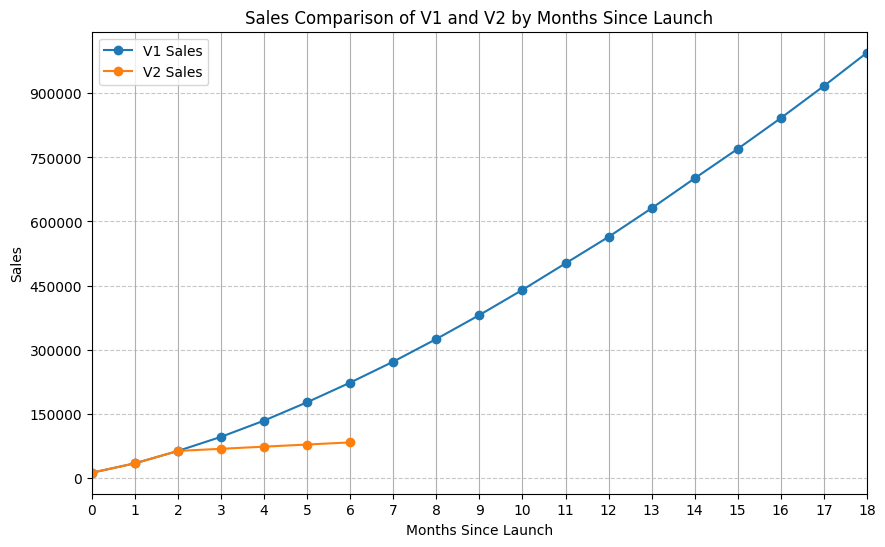

Line chart comparing V1 and V2 sales created successfully.


In [117]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Drop any rows where sales might have become NaN after conversion
df_combined.dropna(subset=['sales'])

# Create the line plot
plt.figure(figsize=(10, 6))

# Plot V1 sales
df_v1_plot = df_combined[df_combined['product'] == 'V1'].sort_values(by='months_since_launch')
plt.plot(df_v1_plot['months_since_launch'], df_v1_plot['sales'], label='V1 Sales', marker='o')

# Plot V2 sales
df_v2_plot = df_combined[df_combined['product'] == 'V2'].sort_values(by='months_since_launch')
plt.plot(df_v2_plot['months_since_launch'], df_v2_plot['sales'], label='V2 Sales', marker='o')

# Customize x-axis
plt.xlabel('Months Since Launch')
plt.xticks(range(0, 19)) # Show whole numbers from 0 to 18
plt.xlim(0, 18) # Set x-axis limits from 0 to 18

# Customize y-axis
plt.ylabel('Sales')
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True)) # Ensure whole number grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add title and legend
plt.title('Sales Comparison of V1 and V2 by Months Since Launch')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

print("Line chart comparing V1 and V2 sales created successfully.")

### Summary:

### Data Analysis Key Findings

*   The `global_gadgets_fork.monthly_product_sales` table was successfully loaded into a pandas DataFrame, providing sales data for V1 and V2 products, along with their respective 'months\_since\_launch' columns.
*   Data preparation involved restructuring the sales data for V1 and V2 into a combined DataFrame (`df_combined`). This DataFrame contains 24 entries, with sales figures and 'months\_since\_launch' values for both products in a unified format, after removing any missing or zero values.
*   A line chart was successfully generated comparing the sales of V1 and V2. The x-axis accurately represents 'Months Since Launch' from 0 to 18, with grid lines showing every whole number. The y-axis displays sales, with grid lines set to whole numbers for clarity.

### Insights or Next Steps

*   The generated chart provides a clear visual comparison of the sales growth trajectories for V1 and V2 products over their respective launch periods, allowing for direct comparison of their performance from inception.
*   A potential next step could involve calculating and plotting the month-over-month growth rate for each product to provide a more detailed understanding of their sales momentum, and identify any specific months where one product significantly outperformed the other in terms of growth.


### Confirming the drop

As can be seen from the chart, the sales of V2 were initially tracking with the growth of V1 at the same point in its lifecycle but then the growth slowed dramatically.

## **2.** AI to Score Unstructured Data at Scale

### Formulating a plan and using the AI Query Engine functions to analyze unstructured data

We've seen some negative product reviews of the V2 speaker and are wondering how much those reviews might be impacting sales. We'll need to look into other factors such as shopper demographics as well.

But first, to wrangle the review data, we'll need to categorize the reviews in terms of how positive or negative EACH review is toward the key product features that are most often mentioned in reviews for this type of product.

We'll use the **AI.GENERATE** function to analyze every V2 product review and to give each review a score from -2 (very negative) to +2 (very positive) with zero being either neutral or not mentioned for each of the four key product features.

The product features are:
* AI Assistant Pro (a new AI assistant added with V2)
* Audio Quality
* Seamless Connectivity
* Smarthome Integration

The following code generates a new table with that information for every V2 product review.

#### To use BigQuery's AI.GENERATE function, we will need to create a BigQuery connection

In [ ]:
from google.cloud import bigquery_connection_v1 as bq_connection
client = bq_connection.ConnectionServiceClient()

CONNECTION_ID = "connection"

try:
    request = client.get_connection(
        request=bq_connection.GetConnectionRequest(name=f"projects/{PROJECT_ID}/locations/{LOCATION}/connections/{CONNECTION_ID}")
    )
    CONN_SERVICE_ACCOUNT = f"serviceAccount:{request.cloud_resource.service_account_id}"

except Exception:
    connection = bq_connection.types.Connection(
        {"friendly_name": CONNECTION_ID, "cloud_resource": bq_connection.CloudResourceProperties({})}
    )
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": f"projects/{PROJECT_ID}/locations/{LOCATION}",
            "connection_id": CONNECTION_ID,
            "connection": connection,
        }
    )
    response = client.create_connection(request)
    CONN_SERVICE_ACCOUNT = (
        f"serviceAccount:{response.cloud_resource.service_account_id}"
    )

print(CONN_SERVICE_ACCOUNT)

Bind the required IAM roles 

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/bigquery.connectionUser'
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/aiplatform.user'

#### Generate scores with BigQuery's AI.GENERATE function

In [ ]:
query = f"""
CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET_ID}.reviews_feature_sentiment_score AS SELECT
  review_id,

  -- Score for "AI Assistant Pro"
  AI.GENERATE((
    'Score the following review based on its sentiment towards "AI Assistant Pro". '
    'This feature refers to the smart assistant\\'s intelligence, responsiveness, and ability to understand commands (e.g., "the assistant is dumb", "the AI can\\'t understand me"). '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{LOCATION}.{CONNECTION_ID}'
  ).result AS ai_assistant_pro_score,

  -- Score for "Audio Quality"
  AI.GENERATE((
    'Score the following review based on its sentiment towards "Audio Quality". '
    'This feature refers to how the speaker sounds (e.g., "great bass", "clear sound", "it\\'s loud"). '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{LOCATION}.{CONNECTION_ID}'
  ).result AS audio_quality_score,

  -- Score for "Seamless Connectivity"
  AI.GENERATE((
    'Score the following review based on its sentiment towards "Seamless Connectivity". '
    'This feature refers to how well the speaker connects to Wi-Fi or Bluetooth (e.g., "connection drops", "setup was easy"). '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{LOCATION}.{CONNECTION_ID}'
  ).result AS seamless_connectivity_score,

  -- Score for "Smart Home Integration"
  AI.GENERATE((
    'Score the following review based on its sentiment towards "Smart Home Integration". '
    'This feature refers to its ability to control other devices like lights or thermostats. '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{LOCATION}.{CONNECTION_ID}'
  ).result AS smart_home_integration_score

FROM
  `{PROJECT_ID}`.{DATASET_ID}.product_reviews
"""

In [ ]:
%%bigquery --project $PROJECT_ID
$query

## **3.** Gathering all of the data: The bigger picture

Now that we have the review sentiment information, we need to do two more things to prepare for our final analysis. We need to look at which site visitors to the V2 product page did NOT convert to purchases and for them:
* Which negatively reviewed features did they see
* What is all of the demographic and device data that we have

We need to prepare a table for a final analysis so that our model can determine the weight of the different features to predict which feature is most influential in visitors choosing NOT to purchase. We need anctionable insights.

The demographic features we'll look at are gender, age range and the urbanicity of the visitors location. The device information we'll consider will be mobile, desktop, tablet.

The code below will identify which V2 product page visits saw which reviews and will have 1-hot columns for the four features to determine if any of those reviews had a very negative review of any of those features. It will also have 1-hot columns for demographic and device informaiton.

This massively joined table will be used in the final analysis.

In [ ]:
# 1. Define the full SQL query using the f-string
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}`.{DATASET_ID}.FINAL_ANALYSIS AS (
WITH
  -- Unnest the comma-separated list of review IDs for each session
  session_reviews_unnested AS (
    SELECT
      session_id,
      -- Using REPLACE to remove single quotes and TRIM for whitespace
      REPLACE(TRIM(review_id), "'", "") AS review_id
    FROM
      `{PROJECT_ID}`.{DATASET_ID}.sessions_reviews,
      UNNEST(SPLIT(reviews_seen, ',')) AS review_id
  )
-- Join all tables and perform the final aggregation
SELECT
  s.session_id,
  s.`session_date_time`,
  s.device_type,
  s.converted,
  -- Create a flag (1 or 0) if any review seen had a score of -2 for each feature
  -- Instead of direct comparison, use COALESCE to handle NULLs
  MAX(IF(COALESCE(scores.ai_assistant_pro_score, "0") = "-2", 1, 0)) AS AI_Assistant_neg_review_seen,
  MAX(IF(COALESCE(scores.audio_quality_score, "0") = "-2", 1, 0)) AS Audio_Quality_neg_review_seen,
  MAX(IF(COALESCE(scores.seamless_connectivity_score, "0") = "-2", 1, 0)) AS Seamless_Connectivity_neg_review_seen,
  MAX(IF(COALESCE(scores.smart_home_integration_score, "0") = "-2", 1, 0)) AS Smart_Home_Integration_neg_review_seen,
  -- One-hot encoded columns from user_info (based on actual distinct values)
  CASE WHEN ui.gender = 'M' THEN 1 ELSE 0 END AS gender_M,
  CASE WHEN ui.gender = 'F' THEN 1 ELSE 0 END AS gender_F,
  CASE WHEN ui.age_range = '31 - 45' THEN 1 ELSE 0 END AS age_range_31_45,
  CASE WHEN ui.age_range = '>60' THEN 1 ELSE 0 END AS age_range_gt60,
  CASE WHEN ui.age_range = '20 - 30' THEN 1 ELSE 0 END AS age_range_20_30,
  CASE WHEN ui.age_range = '46 - 60' THEN 1 ELSE 0 END AS age_range_46_60,
  CASE WHEN ui.age_range = '<20' THEN 1 ELSE 0 END AS age_range_lt20,
  CASE WHEN ui.urbanicity = 'suburban' THEN 1 ELSE 0 END AS urbanicity_suburban,
  CASE WHEN ui.urbanicity = 'rural' THEN 1 ELSE 0 END AS urbanicity_rural,
  CASE WHEN ui.urbanicity = 'urban' THEN 1 ELSE 0 END AS urbanicity_urban,
  -- New one-hot encoded columns for device_type
  CASE WHEN s.device_type = 'desktop' THEN 1 ELSE 0 END AS device_type_desktop,
  CASE WHEN s.device_type = 'mobile' THEN 1 ELSE 0 END AS device_type_mobile,
  CASE WHEN s.device_type = 'tablet' THEN 1 ELSE 0 END AS device_type_tablet
FROM
  `{PROJECT_ID}`.{DATASET_ID}.sessions AS s
  -- Join sessions with the now-clean unnested reviews
  INNER JOIN session_reviews_unnested AS ur ON s.session_id = ur.session_id
  -- Join with the scores table to get the sentiment for each review
  INNER JOIN `{PROJECT_ID}`.{DATASET_ID}.reviews_feature_sentiment_score AS scores ON ur.review_id = scores.review_id
  -- Join with session_to_user_map to get user_id
  INNER JOIN `{PROJECT_ID}`.{DATASET_ID}.session_to_user_map AS stum ON s.session_id = stum.session_id
  -- Join with user_info table
  INNER JOIN `{PROJECT_ID}`.{DATASET_ID}.user_info AS ui ON stum.user_id = ui.user_id
GROUP BY
  s.session_id,
  s.`session_date_time`,
  s.device_type,
  s.converted,
  -- Include new one-hot encoded columns in GROUP BY
  gender_M,
  gender_F,
  age_range_31_45,
  age_range_gt60,
  age_range_20_30,
  age_range_46_60,
  age_range_lt20,
  urbanicity_suburban,
  urbanicity_rural,
  urbanicity_urban,
  -- New one-hot encoded columns for device_type in GROUP BY
  device_type_desktop,
  device_type_mobile,
  device_type_tablet
)
"""

In [ ]:
%%bigquery --project $PROJECT_ID
$query

## **4.** Model to predict the feature weight: The data science heavy lifting with the Data Science Agent

Now that we have all of the data in a final table ready for analysis, we'll ask the Data Science Agent to run an XGBOOST model to identify the feature weights and to visualize the weights. The prompt below was used the generate the code and analysis that follows. It is included here for demonstration purposes.

Our hope is that we can identify key factor(s) driving the drop in sales growth so that we can take corrective action.

**The Prompt:**

*Using the FINAL_ANALYSIS table, create an XGBOOST model to determine to what degree any demographic factors or device types or negative review seen is impacting why a shopper decided not to purchase the device. Show a visualization of the feature importance.*

### Task
Create an XGBoost model using the data from `FINAL_ANALYSIS` table to determine the impact of demographic factors, device types, and negative reviews on shopper purchase decisions.

### Data loading

### Subtask:
Load the `FINAL_ANALYSIS` table into a pandas DataFrame.


**Reasoning**:
To load the `FINAL_ANALYSIS` table into a pandas DataFrame, I will import `pandas_gbq`, define the project and table IDs, construct the SQL query, and then use `gbq.read_gbq` to fetch the data. Finally, I will display the head and info of the DataFrame to confirm successful loading.



In [ ]:
df_final_analysis = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.FINAL_ANALYSIS")

print("Data loaded successfully. Displaying the first 5 rows:")
df_final_analysis.head()
print("\nInfo of the DataFrame:")
df_final_analysis.info()

### Data preprocessing

### Subtask:
Prepare the data for the XGBoost model, including handling categorical features and splitting into training and testing sets.


**Reasoning**:
To prepare the data for the XGBoost model, I will separate the target and features, drop irrelevant columns, and then split the data into training and testing sets as per the instructions.



In [ ]:
from sklearn.model_selection import train_test_split

df_final_analysis = df_final_analysis.to_pandas()

# Separate target variable 'converted' from features
X = df_final_analysis.drop('converted', axis=1)
y = df_final_analysis['converted']

# Drop irrelevant columns from features DataFrame
X = X.drop(['session_id', 'session_date_time', 'device_type'], axis=1)

# Split the data into training and testing sets (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared and split into training and testing sets successfully.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

### Model training

### Subtask:
Train an XGBoost classification model.


**Reasoning**:
To train the XGBoost classification model, I will import `XGBClassifier`, instantiate it with the specified parameters to avoid warnings, and then fit the model to the training data.



In [ ]:
import xgboost as xgb

# Instantiate XGBClassifier
# Setting use_label_encoder=False and eval_metric='logloss' to suppress warnings
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
model.fit(X_train, y_train)

print("XGBoost classification model trained successfully.")

### Model evaluation

### Subtask:
Evaluate the trained model's performance.


**Reasoning**:
To evaluate the model, I will import the necessary metrics from `sklearn.metrics`, make predictions on the test set, and then compute and display the accuracy, precision, recall, and F1-score.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Model Evaluation Metrics:\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

### Feature importance analysis

### Subtask:
Determine the importance of each feature in predicting shopper purchase decisions.


**Reasoning**:
To determine feature importance, I will access the trained model's `feature_importances_` attribute, create a pandas Series with feature names from `X_train`, sort it, and then print the results.



In [ ]:
import pandas as pd

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a pandas Series with feature names
feature_names = X_train.columns
importance_df = pd.Series(feature_importances, index=feature_names)

# Sort feature importances in descending order
sorted_importance = importance_df.sort_values(ascending=False)

print("Feature Importances (sorted descending):")
print(sorted_importance)

### Summary:

### Q&A

**To what degree are demographic factors, device types, or negative reviews impacting why a shopper decided not to purchase the device?**

The XGBoost model indicates that the most significant factor impacting a shopper's decision not to purchase (or conversion) is `AI_Assistant_neg_review_seen`, with an importance score of approximately 0.74. This suggests that whether a shopper has viewed negative reviews related to AI Assistant features is highly influential. Other impactful factors, though to a much lesser degree, include `urbanicity_rural` (0.079), `age_range_46_60` (0.046), and `device_type_mobile` (0.044). Several demographic factors (like gender_F) and other negative review categories (Audio Quality, Seamless Connectivity, Smart Home Integration) showed zero importance in this model.

### Data Analysis Key Findings

*   The `FINAL_ANALYSIS` table, containing 10884 entries and 21 columns, was successfully loaded into a pandas DataFrame.
*   The data was successfully preprocessed, separating the target variable 'converted' from 17 features, and then split into training (8707 samples) and testing (2177 samples) sets.
*   An XGBoost classification model was successfully trained on the prepared data.
*   The trained model achieved an accuracy of 0.8222. However, the precision, recall, and F1-score for the positive class (converted) were 0.0000. This indicates that the model did not predict any positive conversions in the test set, likely due to a significant class imbalance in the target variable.
*   Feature importance analysis revealed that `AI_Assistant_neg_review_seen` is by far the most influential factor, contributing to approximately 74% of the feature importance.
*   Other features with notable, but significantly lower, importance include `urbanicity_rural` (0.079), `age_range_46_60` (0.046), and `device_type_mobile` (0.044).
*   Several features, including `gender_F`, `Audio_Quality_neg_review_seen`, `Seamless_Connectivity_neg_review_seen`, and `Smart_Home_Integration_neg_review_seen`, showed no importance (0.0000) in this model.

### Insights or Next Steps

*   The dominance of `AI_Assistant_neg_review_seen` as a predictor highlights a critical area for improving conversion rates. Businesses should investigate the content of these negative reviews and consider strategies to mitigate their impact, such as improving AI Assistant features or proactively addressing common complaints.
*   The model's inability to predict any positive conversions (Precision, Recall, F1-Score of 0.0000) strongly suggests a class imbalance issue. Future steps should involve addressing this imbalance using techniques like oversampling (SMOTE), undersampling, or adjusting class weights in the XGBoost model to improve its ability to identify and predict conversions.


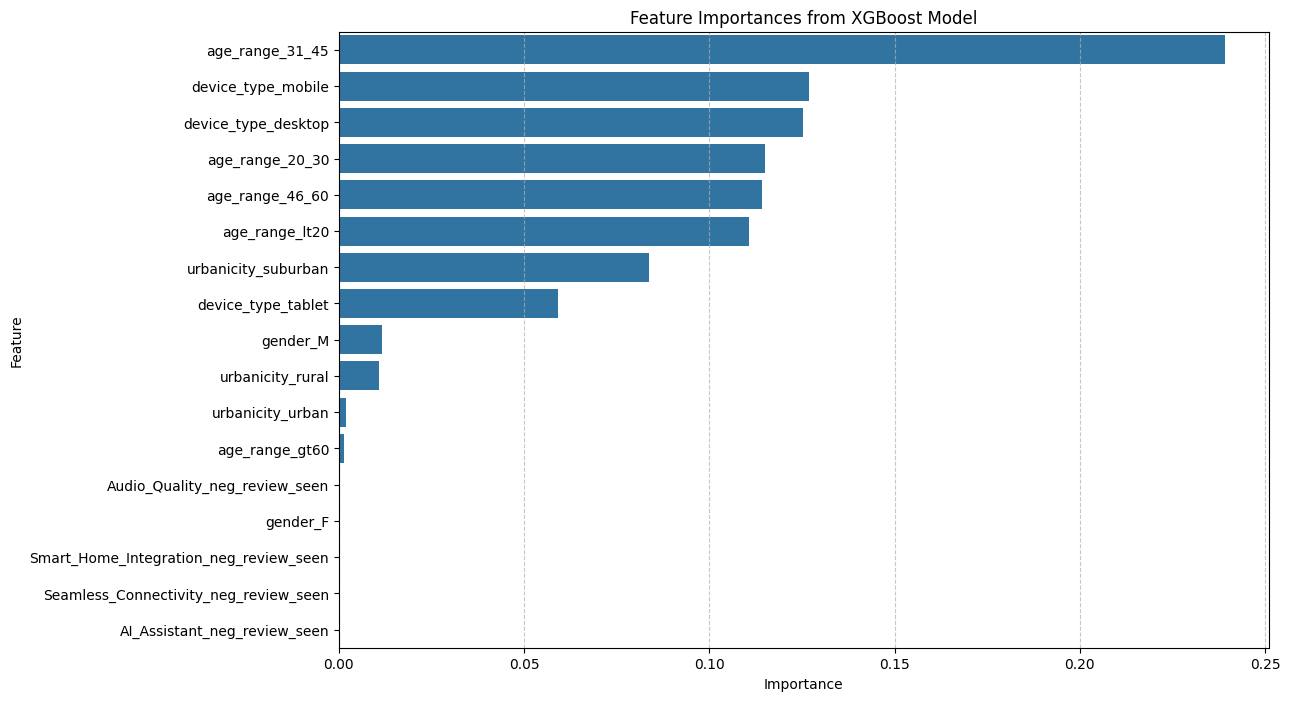

Feature importance visualization created successfully.


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot of feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importance.values, y=sorted_importance.index)
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Feature importance visualization created successfully.")

## **5.** Closing: AI scoring at scale and agentic assist are force multipliers

This visualization provides clear confirmation that the product reviews are most responsible for the decline in sales growth. In particular, it is the AI Assistant feature that is being poorly reviewed and when shoppers see those negative reviews they are choosing not to purchase.

This gives us immediate actionable insight and means that our engineering team should be laser focused on addressing the complaints, bugs, issues with the AI Assistant Pro.

The Data Science Agent provides **a powerful multiplier effect for our data scientists,** allowing them to rapidly build, train, and deploy models, delivering critical, actionable intelligence at an unprecedented pace.

As you can see from this notebook, what at first seemed like a difficult question that would have required a team and several days, was quickly broken down and identified within minutes using Google AI Query Engine and Data Science Agent.

